In [1]:
import cv2
import pandas as pd
import pickle
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler

sns.set_style("darkgrid")
sns.set_context("notebook")
pd.set_option('display.precision', 3)
plt.rcParams.update({
    'text.usetex': True,
    'font.family': 'Helvetica',
    'font.size': 22,
    'axes.labelsize': 18,
    'axes.titlesize':18, 
    'legend.fontsize': 16, 
    'xtick.labelsize': 16, 
    'ytick.labelsize': 18,
})

In [2]:
models = ['elo', 'trueskill', 'cvxopt', 'gaussianprocess', 'rankcentrality', 'lucespectralranking']
seeds = [1, 2, 3, 4, 5]

In [3]:
model_results = []
for seed in seeds:
    for model in models:
        try:
            model_results.append(pickle.load(open('output/{}_modelresults_SEED{}.p'.format(model, seed), 'rb')))
        except FileNotFoundError:
            continue
model_results = pd.DataFrame(model_results)

In [4]:
average_results = {}
for model in models:
    average_results[model] = model_results[model_results.model == model].mean(numeric_only=True)
average_results = pd.DataFrame(average_results).T

In [5]:
average_results

,train_logloss,test_logloss,train_accuracy,test_accuracy,seed
elo,0.580,0.658,0.904,0.658,3.0
trueskill,0.288,0.631,0.945,0.660,3.0
cvxopt,0.630,0.750,0.970,0.606,3.0
gaussianprocess,0.796,0.839,0.917,0.671,3.0
rankcentrality,0.692,0.693,0.890,0.653,3.0
lucespectralranking,0.349,0.623,0.931,0.654,3.0


In [6]:
print(average_results.to_latex())

\begin{tabular}{lrrrrr}
\toprule
{} &  train\_logloss &  test\_logloss &  train\_accuracy &  test\_accuracy &  seed \\
\midrule
elo                 &          0.580 &         0.658 &           0.904 &          0.658 &   3.0 \\
trueskill           &          0.288 &         0.631 &           0.945 &          0.660 &   3.0 \\
cvxopt              &          0.630 &         0.750 &           0.970 &          0.606 &   3.0 \\
gaussianprocess     &          0.796 &         0.839 &           0.917 &          0.671 &   3.0 \\
rankcentrality      &          0.692 &         0.693 &           0.890 &          0.653 &   3.0 \\
lucespectralranking &          0.349 &         0.623 &           0.931 &          0.654 &   3.0 \\
\bottomrule
\end{tabular}



/tmp/ipykernel_4854/2378778435.py:1: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(average_results.to_latex())


# Scores

In [7]:
scores = []
for seed in [1]:
    for model in models:
        try:
            scores.append(pickle.load(open('output/{}_scores_SEED{}.p'.format(model, seed), 'rb')))
        except FileNotFoundError:
            continue
#scores = pd.DataFrame(scores)

In [10]:
def draw_sequence(samples):
    n_samples = 5
    fig = plt.figure(figsize = (28,20))
    gs = gridspec.GridSpec(7, n_samples)
    gs.update(wspace=0.025, hspace=0.05) # set the spacing between axes. 
    
    #samples = scores[0][scores[0].score < scores[0].score.mean()].sample(n_samples).sort_values(by=['score']).index
    
    
    scaler = MinMaxScaler()
    scores_df = scores[0]
    scores_model = scores_df.loc[samples]
    scores_model['score'] = scaler.fit_transform(scores_model['score'].values.reshape(-1,1))
    
    count = 0
    for i, row in scores_model.iterrows():
        # Read image from disk
        img_1 = cv2.cvtColor(cv2.imread(row['image_path']), cv2.COLOR_BGR2RGB)

        # Plot image
        ax = plt.subplot(gs[count])
        ax.imshow(img_1);
        plt.axis('on')
        ax.set_xticklabels([])
        ax.set_yticklabels([])
        ax.set_aspect('equal')
        count += 1
        ax.tick_params(
            axis='both',          # changes apply to the x-axis
            which='both',      # both major and minor ticks are affected
            bottom=False,      # ticks along the bottom edge are off
            top=False,         # ticks along the top edge are off
            labelbottom=False,
            grid_alpha=0)

    ax1 = fig.add_subplot(gs[1, :])
    ax1.tick_params(
        axis='y',          # changes apply to the x-axis
        which='both',      # both major and minor ticks are affected
        left=False,        # ticks along the bottom edge are off
        right=False,       # ticks along the top edge are off
        labelbottom=False)

    # Elo
    scores_df = scores[0]
    scores_model = scores_df.loc[samples]
    scores_model['score'] = scaler.fit_transform(scores_model['score'].values.reshape(-1,1))
    color = 'tab:red'
    ax1.set_xlabel('Images')
    ax1.set_ylabel('Perceived Score',)
    line_elo = ax1.errorbar([str(j+1) for j in range(n_samples)], scores_model['score'].to_list(), yerr=[0 for j in range(n_samples)], 
                 fmt='-o', color=color, 
                 label='Elo'
                );
    ax1.tick_params(axis='y', which='both', left=False, right=False, labelbottom=False)
    ax1.set_xticks([str(i+1) for i in range(n_samples)])

    # TS
    scores_df = scores[1]
    scores_model = scores_df.loc[samples]
    scores_model['score'] = scaler.fit_transform(scores_model['score'].values.reshape(-1,1))
    color = 'tab:green'
    ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
    line_ts = ax2.errorbar([str(j+1) for j in range(n_samples)], scores_model['score'].to_list(), yerr=[0 for j in range(n_samples)], 
                 fmt='-o', color=color,
                 label='TS'
                );
    ax2.tick_params(axis='y', which='both', left=False, right=False, labelbottom=False, grid_alpha=0)
    ax2.set_yticks([])

    # CVX OPT
    scores_df = scores[2]
    scores_model = scores_df.loc[samples]
    scores_model['score'] = scaler.fit_transform(scores_model['score'].values.reshape(-1,1))
    color = 'tab:orange'
    ax3 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
    line_cvxopt = ax3.errorbar([str(j+1) for j in range(n_samples)], scores_model['score'].to_list(), yerr=[0 for j in range(n_samples)], 
                 fmt='-o', color=color,
                 label='CO'
                );
    ax3.tick_params(axis='y', which='both', left=False, right=False, labelbottom=False, grid_alpha=0)
    ax3.set_yticks([])

    # GP
    scores_df = scores[3]
    scores_model = scores_df.loc[samples]
    scores_model['score'] = scaler.fit_transform(scores_model['score'].values.reshape(-1,1))
    color = 'tab:purple'
    ax4 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
    line_gp = ax4.errorbar([str(j+1) for j in range(n_samples)], scores_model['score'].to_list(), yerr=[0 for j in range(n_samples)], 
                 fmt='-o', color=color,
                 label='GP'
                );
    ax4.tick_params(axis='y', which='both', left=False, right=False, labelbottom=False, grid_alpha=0)
    ax4.set_yticks([])

#    # RC
#    scores_df = scores[4]
#    scores_model_sequence = scores_df[scores_df.sequence_id == sequence.split('_')[1]].sort_values(by='image_id')
#    scores_model_sequence['score'] = scaler.fit_transform(scores_model_sequence['score'].values.reshape(-1,1))
#    color = 'tab:cyan'
#    ax5 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
#    line_rc = ax5.errorbar(scores_model_sequence['image'].to_list(), scores_model_sequence['score'].to_list(), yerr=[0 for j in range(7)], 
#                 fmt='-o', color=color,
#                 label='RC'
#                );
#    ax5.tick_params(axis='y', which='both', left=False, right=False, labelbottom=False, grid_alpha=0)
#    ax5.set_yticks([])

    # LSR
    scores_df = scores[5]
    scores_model = scores_df.loc[samples]
    scores_model['score'] = scaler.fit_transform(scores_model['score'].values.reshape(-1,1))
    color = 'tab:blue'
    ax6 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
    line_lsr = ax6.errorbar([str(j+1) for j in range(n_samples)], scores_model['score'].to_list(), yerr=[0 for j in range(n_samples)], 
                 fmt='-o', color=color,
                 label='LSR'
                );
    ax6.tick_params(axis='y', which='both', left=False, right=False, labelbottom=False, grid_alpha=0)
    ax6.set_yticks([])

    ax1.legend(handles=[line_elo, line_ts, line_cvxopt, line_gp,  line_lsr], 
               ncols=6, bbox_to_anchor=(0.685, -.43))
    #fig.tight_layout()  # otherwise the right y-label is slightly clipped
    #plt.savefig('sequence_scores/{}.png'.format(sequence), bbox_inches='tight')

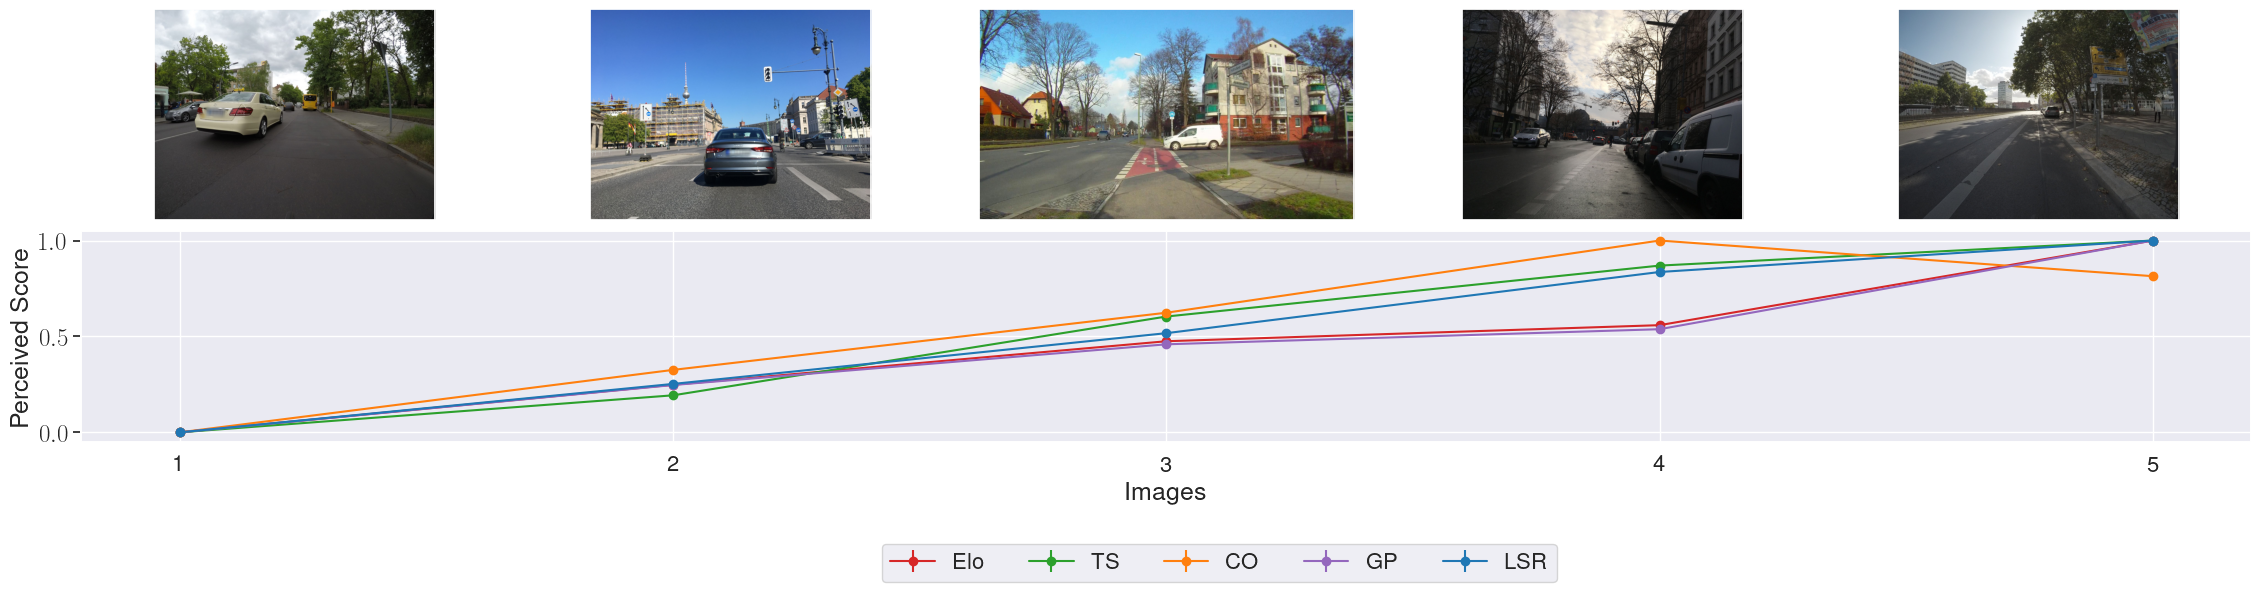

In [11]:
samples = ['9553', '22', '4210', '2218', '15']
draw_sequence(samples)